In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

from functions import preprocess, train_default_catboost

In [163]:
df0 = pd.read_csv('./data/train.csv').set_index('ID')

In [229]:
# df0.query('Регион_ПП=="Алтай Респ"')

In [3]:
df_train, df_test = preprocess('./data/train.csv'), preprocess('./data/test.csv')

In [144]:
# df0.loc[df0['Уч_Заведение'].fillna('').str.contains('КГБОУ'), 'Уч_Заведение'].value_counts().head(20)

In [244]:
# df0.loc[47817]

In [245]:
# df_train.loc[47817]

In [4]:
df_train['Учеба'].value_counts()

ш        7150
алтгу    2899
к        1463
н        1285
у         657
Name: Учеба, dtype: int64

In [5]:
df_train.head()

,Код_группы,Год_Поступления,Основания,КодФакультета,СрБаллАттестата,Статус,Код1,Код2,Код3,Муж,Год_Рождения,Возраст_Поступления,Перерыв,ПолнаяСемья,Учеба,МестоЖит
ID,,,,,,,,,,,,,,,,
72716,16019,2015,оо,41,85.88,3,16,01,019,False,1998,17,1,False,ш,брн
63306,14895,2010,цн,28,67.00,4,14,89,895,True,1992,18,0,True,н,брн
82469,20103,2017,дн,41,82.66,4,20,10,103,False,1999,18,0,True,ш,алт
81661,19838,2017,бн,35,74.00,4,19,83,838,False,1994,23,0,True,алтгу,брн
81509,19803,2017,бн,28,53.00,4,19,80,803,False,1995,22,0,True,алтгу,брн


In [6]:
df_train.dtypes

Код_группы             category
Год_Поступления           int64
Основания              category
КодФакультета          category
СрБаллАттестата         float64
Статус                    int64
Код1                   category
Код2                   category
Код3                   category
Муж                        bool
Год_Рождения              int64
Возраст_Поступления       int64
Перерыв                   int64
ПолнаяСемья                bool
Учеба                  category
МестоЖит               category
dtype: object

In [7]:
X, y = df_train.drop(['Статус'], axis=1, errors='ignore'), df_train['Статус'].replace({-1: 0, 3: 1, 4: 2})
X_test = df_test.drop(['Статус'], axis=1, errors='ignore')

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [9]:
from sklearn.model_selection import cross_val_score
from skopt import BayesSearchCV
from catboost import CatBoostClassifier, Pool

In [78]:
?CatBoostClassifier

Init signature:
CatBoostClassifier(
    iterations=None,
    learning_rate=None,
    depth=None,
    l2_leaf_reg=None,
    model_size_reg=None,
    rsm=None,
    loss_function=None,
    border_count=None,
    feature_border_type=None,
    per_float_feature_quantization=None,
    input_borders=None,
    output_borders=None,
    fold_permutation_block=None,
    od_pval=None,
    od_wait=None,
    od_type=None,
    nan_mode=None,
    counter_calc_method=None,
    leaf_estimation_iterations=None,
    leaf_estimation_method=None,
    thread_count=None,
    random_seed=None,
    use_best_model=None,
    best_model_min_trees=None,
    verbose=None,
    silent=None,
    logging_level=None,
    metric_period=None,
    ctr_leaf_count_limit=None,
    store_all_simple_ctr=None,
    max_ctr_complexity=None,
    has_time=None,
    allow_const_label=None,
    target_border=None,
    classes_count=None,
    class_weights=None,
    auto_class_weights=None,
    class_names=None,
    one_hot_max_size=Non

In [10]:
from catboost import cv, Pool

params = {
    'loss_function': 'MultiClass',
    'iterations': 1000,
    'custom_metric': 'TotalF1:average=Macro',
    'random_seed': 63,
    # 'learning_rate': 0.1,
    # 'class_weights': [1, 1, 1],
    # 'l2_leaf_reg': 2,
    # 'depth': 4,
    # 'min_data_in_leaf': 5,
}
cat_features = np.arange(len(X_train.columns))[X_train.dtypes == 'category']

cv_data = cv(
    params=params,
    pool=Pool(X, label=y, cat_features=cat_features),
    fold_count=3,
    shuffle=True,
    partition_random_seed=0,
    plot=False,
    stratified=True, 
    verbose=False
)

Training on fold [0/3]

bestTest = 0.2919865007
bestIteration = 997

Training on fold [1/3]

bestTest = 0.2803470009
bestIteration = 999

Training on fold [2/3]

bestTest = 0.283628991
bestIteration = 991



In [12]:
def plot_learning_curve(cv_data):
    import matplotlib.pyplot as plt
    def plot_line(x, y, yerr, ax, label):
        label = f'{label} ({y.iloc[-1]:.3f}±{yerr.iloc[-1]:.3f})'
        ax.errorbar(x, y, label=label)
        ax.fill_between(x, y-yerr, y+yerr, alpha=0.3)

    fig, ax = plt.subplots(1, 1, dpi=120)
    plot_line(
        cv_data.iterations,
        cv_data['train-TotalF1:average=Macro-mean'], 
        cv_data['train-TotalF1:average=Macro-std'], 
        ax, 'train')

    plot_line(
        cv_data.iterations,
        cv_data['test-TotalF1:average=Macro-mean'], 
        cv_data['test-TotalF1:average=Macro-std'], 
        ax, 'val')

    ax.set(xlabel='Iteration', ylabel='F1 Macro', xlim=(0, None))
    ax.legend();
    return

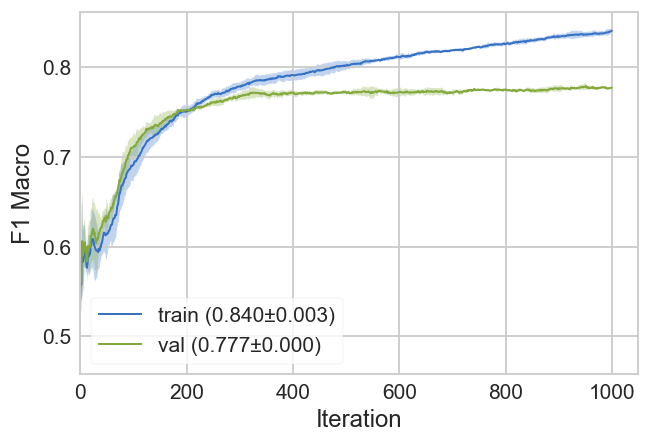

In [13]:
plot_learning_curve(cv_data)

In [14]:
clf = train_default_catboost(X, y, X_test, 'results/catboost_default.csv')

Train len: 10763, val len: 2691, test len: 6691
F1 train: 0.8726278435721581 F1 test: 0.8046718442871524
{'Код_группы': 15.486011521019023, 'Год_Поступления': 5.064590438606504, 'Основания': 10.15054038480599, 'КодФакультета': 10.177219594893597, 'СрБаллАттестата': 5.483844086139773, 'Код1': 15.986801195257504, 'Код2': 11.653504999423957, 'Код3': 5.997569956605617, 'Муж': 1.4281236157230028, 'Год_Рождения': 3.4013678716522637, 'Возраст_Поступления': 2.443998509187723, 'Перерыв': 2.0114145927922307, 'ПолнаяСемья': 1.0939270421583327, 'Учеба': 6.131384522295136, 'МестоЖит': 3.489701669439228}
